# Intro and function definitions

We have 108 databases of different tissue/seed/method combinations. Now we'd like to know how much of the genome we cover in each case. 

In [1]:
# Import packages
library('dplyr') # For dataframe manipulation
library('GenomicRanges') # For doing overlaps and reductions
library('purrr') # For combining dataframes quickly
library('BiocParallel') # For parallel computations
library('RPostgreSQL') # For reading from databases
library('ggpubr') # For plotting


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

## Function Definitions

In [2]:
# First, create a function that reads the FIMO data for one chromosome
getRegionsForChrom <- function(chromosome){
    
    fimo.conn <- dbConnect(PostgreSQL(),
                       user = "trena",
                       password = "trena",
                       port = "5432",
                       host = "khaleesi",
                       dbname = "fimo"                    
                      )
    
    # Print out what chromosome we're using
    to.print <- sprintf("Working on %s", chromosome)
    print(to.print)
    # Make a string for the chromosome
    query <- sprintf("select chrom, start, endpos from fimo_hg38 where chrom = '%s';",
                     chromosome)
    fimo.data <- dbGetQuery(fimo.conn, query)
    dbDisconnect(fimo.conn)
    
    # Print out the number of records retrieved
    to.print <- sprintf("%d records retrieved for %s", nrow(fimo.data), chromosome)
    return(fimo.data)
}

In [3]:
# Function for counting coverage as % of human genome, given a genomic range
calculateGenomeCoverage <- function(my.range){
    
    # Use the "reduce" function to calculate the total areas covered
    reduced.range <- GenomicRanges::reduce(my.range)
    
    # Sum the areas using the "width" operator to get each area
    total.bp <- sum(as.numeric(width(reduced.range)))
    
    # Divide by total human genome length and return result (a decimal)
    # my.coverage <- total.bp/3253848404
    return(total.bp)
}

In [4]:
# Make a function that takes tissue name and figures out the pathway to its footprints
compileFootprintPaths <- function(tissue){
    
    # Create the 4 strings from the tissue
    hint.20 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_hint_20")
    hint.16 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_hint_16")
    well.20 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_wellington_20")
    well.16 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_wellington_16")
    
    # Create all the paths
    hint.20.paths <- list.files(hint.20)
    hint.20.paths <- file.path(hint.20, hint.20.paths)
    
    hint.16.paths <- list.files(hint.16)
    hint.16.paths <- file.path(hint.16, hint.16.paths)
    
    well.20.paths <- list.files(well.20)
    well.20.paths <- file.path(well.20, well.20.paths)
    
    well.16.paths <- list.files(well.16)
    well.16.paths <- file.path(well.16, well.16.paths)
    
    # Stick the paths together and return them
    all.paths <- c(hint.20.paths,
                   hint.16.paths,
                   well.20.paths,
                   well.16.paths
                  )
    
    return(all.paths)
}

In [5]:
# Define a function that takes pathways and uses them to read FPs
readFootprintTable <- function(fp.path){
    tbl <- read.table(fp.path, sep = "\t", as.is = TRUE)
    colnames(tbl) <- c("chrom", "start", "end", "name", "score", "strand")
    # Make sure it's just the first 6 columns
    tbl <- tbl[,c("chrom", "start", "end", "name", "score", "strand")]
    return(tbl)
}

In [6]:
# Define a function that takes a list of footprint dataframes and makes it into a genomic range
footprintsToGenomicRange <- function(fp.list){
    
    # Remove the non-start/end/stop columns
    to.keep <- c("chrom","start","end")
    fp.list <- lapply(fp.list,dplyr::select, one_of(to.keep))
    
    # Collapse into one data frame
    fp.df <- purrr::reduce(fp.list, dplyr::union)
    
    # Convert it into a genomic range
    my.gr <- with(fp.df, GRanges(seqnames=chrom, IRanges(start=start, end=end)))
    
    return(my.gr)
}

In [7]:
# Build a function that takes the tissue and goes all the way through to coverage
coverageFromTissue <- function(tissue){
    
    # First find the footprints
    fp <- compileFootprintPaths(tissue)
    
    # Then use a parallel process to read all the footprints
    my.message <- sprintf("Reading %d files for %s", length(fp), tissue)
    print(my.message)
    register(MulticoreParam(workers = 30, stop.on.error = TRUE, log = FALSE), default = TRUE)
    fp.list <- bptry(bplapply(fp, readFootprintTable))
    
    # Turn the footprint list into a genomic range
    fp.gr <- footprintsToGenomicRange(fp.list)
    rm(fp.list)
    
    # Find the coverage
    fp.coverage <- calculateGenomeCoverage(fp.gr)
    return(fp.coverage)
}

# Part 1: Calculate total overlap of FIMO

The FIMO database we use is massive and contains a lot of ranges; however, it doesn't cover EVERYTHING. We want to:

1. Read FIMO into a data frame from its database
2. Turn FIMO into a GenomicRanges object
3. Use our function to determine how much of the genome it covers

Unfortunately, we can't read it all at once, so let's see if we can break it into chromosomes and read it that way! 

In [53]:
# Test on just the y chromosome
chrom <- "Y"
system.time(test <- getRegionsForChrom(chrom))

[1] "Working on Y"


   user  system elapsed 
  3.516   0.252   8.716 

In [55]:
chroms <- c(1:22, "X","Y", "MT")
register(MulticoreParam(workers = 25, stop.on.error = TRUE, log = TRUE), default = TRUE)
   
# Run it
system.time(all.chroms.list <- bptry(bplapply(chroms, getRegionsForChrom)))

############### LOG OUTPUT ###############
Task: 25
Node: 25
Timestamp: 2017-10-19 08:02:58
Success: TRUE
Task duration:
   user  system elapsed 
  0.012   0.004   2.298 
Memory used:
           used  (Mb) gc trigger   (Mb)   max used    (Mb)
Ncells  2020960 108.0   55774197 2978.7  110856919  5920.4
Vcells 89422924 682.3 1129456322 8617.1 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on MT"
############### LOG OUTPUT ###############
Task: 24
Node: 24
Timestamp: 2017-10-19 08:03:11
Success: TRUE
Task duration:
   user  system elapsed 
  4.040   1.804  13.263 
Memory used:
            used  (Mb) gc trigger   (Mb)   max used    (Mb)
Ncells   2021000 108.0   44619357 2383.0  110856919  5920.4
Vcells 109469887 835.2  903565057 6893.7 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on Y"
############### LOG OUTPUT ###############
Task: 21
Node: 21
Timestamp: 2017-10-19 08:05:28
Success: TRUE
Task duration:
   user  system elapsed 
  8.956   8.768 148.634 

   user  system elapsed 
159.120 147.420 566.772 

In [56]:
# Convert to a DF
full.fimo <- bind_rows(all.chroms.list)

Make it into a GRanges object

In [58]:
gr.fimo <- with(full.fimo, GRanges(seqnames=chrom, IRanges(start=start, end=endpos)))

Find the coverage

In [62]:
system.time(fimo.coverage <- calculateGenomeCoverage(gr.fimo))

   user  system elapsed 
206.532   3.696 210.247 

In [63]:
100* fimo.coverage/3253848404

[1] 78.13244

# Part 2: Calculate the coverage for each tissue

Find the coverage for each tissue, using all methods AND seeds for each tissue. Do this using lapply; don't use bplapply, as that's already being used in the inner functions

In [16]:
all.tissues <- c("adrenal_gland",
                 "blood_vessel",
                 "bone_element",
                 "brain",
                 "bronchus",
                 "esophagus",
                 "extraembryonic_structure",
                 "eye",
                 "gonad",
                 "heart",
                 "kidney",
                 "large_intestine",
                 "liver",
                 "lung",
                 "lymphatic_vessel",
                 "lymphoblast",
                 "mammary_gland",
                 "mouth",
                 "muscle_organ",
                 "pancreas",
                 "prostate_gland",
                 "skin",
                 "spinal_cord",
                 "stomach",
                 "thyroid_gland",
                 "tongue",
                 "urinary_bladder"                
                )
length(all.tissues)

[1] 27

In [111]:
# Note: This takes ~4.5 hours
system.time(all.widths <- lapply(all.tissues, coverageFromTissue))

[1] "Reading 12 files for adrenal_gland"
[1] "Reading 40 files for blood_vessel"
[1] "Reading 4 files for bone_element"
[1] "Reading 116 files for brain"
[1] "Reading 8 files for bronchus"
[1] "Reading 8 files for esophagus"
[1] "Reading 44 files for extraembryonic_structure"
[1] "Reading 32 files for eye"
[1] "Reading 10 files for gonad"
[1] "Reading 30 files for heart"
[1] "Reading 32 files for kidney"
[1] "Reading 20 files for large_intestine"
[1] "Reading 10 files for liver"
[1] "Reading 28 files for lung"
[1] "Reading 8 files for lymphatic_vessel"
[1] "Reading 84 files for lymphoblast"
[1] "Reading 8 files for mammary_gland"
[1] "Reading 16 files for mouth"
[1] "Reading 14 files for muscle_organ"
[1] "Reading 8 files for pancreas"
[1] "Reading 8 files for prostate_gland"
[1] "Reading 184 files for skin"


ERROR: Error in UseMethod("select_"): no applicable method for 'select_' applied to an object of class "character"


Timing stopped at: 8860 1092 1.725e+04


In [ ]:
tissue.coverage <- data_frame(Tissue = all.tissues,
                              Total.Width = unlist(all.widths),
                              Coverage = 100*Total.Width/3253848404
                             )

In [ ]:
tissue.coverage %>% arrange(desc(Coverage))

In [ ]:
saveRDS(tissue.coverage, "./allCoverage.RDS")

In [21]:
# Load the DF if necessary
tissue.coverage <- readRDS("./allCoverage.RDS")

In [22]:
tissue.coverage <- filter(tissue.coverage, Tissue != "extraembryonic_structure")
tissue.coverage

Tissue,Total.Width,Coverage
brain,485325656,14.915435
skin,318498047,9.788349
lymphoblast,289361515,8.892901
eye,207309541,6.371211
heart,193291371,5.940393
kidney,183101528,5.627230
lung,166876505,5.128589
blood_vessel,147439372,4.531231
large_intestine,143353494,4.405660
mouth,127645515,3.922909


Add on the extraembryonic_structure data, which is updated now.

*Note: extraembryonic_structure previously had 241 million/7.4%, this is SLIGHTLY higher*

In [12]:
system.time(ext.coverage <- coverageFromTissue(tissue = "extraembryonic_structure"))

[1] "Reading 44 files for extraembryonic_structure"


   user  system elapsed 
799.716  29.948 837.782 

In [23]:
ext.df <- data_frame(Tissue = 'extraembryonic_structure',
                              Total.Width = ext.coverage,
                              Coverage = 100*Total.Width/3253848404
                             )
tissue.coverage <- bind_rows(tissue.coverage, ext.df) %>% arrange(desc(Total.Width))
tissue.coverage

Tissue,Total.Width,Coverage
brain,485325656,14.915435
skin,318498047,9.788349
lymphoblast,289361515,8.892901
extraembryonic_structure,241332064,7.416820
eye,207309541,6.371211
heart,193291371,5.940393
kidney,183101528,5.627230
lung,166876505,5.128589
blood_vessel,147439372,4.531231
large_intestine,143353494,4.405660


In [24]:
# Add it to the dataframe and save it
saveRDS(tissue.coverage, "./allCoverageUpdatedExtStruc.RDS")

# Part 3: Find combined tissue coverage

This is basically like Part 2, but instead of calculating coverage individually, we'll have to combine all of the ranges to create one BIG range. 

A function that takes either a fp list and combines into one BIG range or, alternative, a bunch of GR ranges and combines them into one range, would be useful...

In [25]:
# Function to turn tissue into reduced GR
createFullCoverage <- function(tissue){
    
    # First run the same things as before (with tissue -> coverage code)
    # First find the footprints
    fp <- compileFootprintPaths(tissue)

    # Then use a parallel process to read all the footprints
    my.message <- sprintf("Reading %d files for %s", length(fp), tissue)
    print(my.message)
    register(MulticoreParam(workers = 30, stop.on.error = TRUE, log = FALSE), default = TRUE)
    fp.list <- bptry(bplapply(fp, readFootprintTable))
    
    # Turn the footprint list into a genomic range
    fp.gr <- footprintsToGenomicRange(fp.list)
    rm(fp.list)
    
    # Reduce the genomic range
    reduced.gr <- GenomicRanges::reduce(fp.gr)
    
    # Return a reduced GR
    return(reduced.gr)
}

In [26]:
# Run for all tissues
system.time(reduced.list <- lapply(all.tissues, createFullCoverage))

[1] "Reading 12 files for adrenal_gland"
[1] "Reading 40 files for blood_vessel"
[1] "Reading 4 files for bone_element"
[1] "Reading 116 files for brain"
[1] "Reading 8 files for bronchus"
[1] "Reading 8 files for esophagus"
[1] "Reading 44 files for extraembryonic_structure"
[1] "Reading 32 files for eye"
[1] "Reading 10 files for gonad"
[1] "Reading 30 files for heart"
[1] "Reading 32 files for kidney"
[1] "Reading 20 files for large_intestine"
[1] "Reading 10 files for liver"
[1] "Reading 28 files for lung"
[1] "Reading 8 files for lymphatic_vessel"
[1] "Reading 84 files for lymphoblast"
[1] "Reading 8 files for mammary_gland"
[1] "Reading 16 files for mouth"
[1] "Reading 14 files for muscle_organ"
[1] "Reading 8 files for pancreas"
[1] "Reading 8 files for prostate_gland"
[1] "Reading 184 files for skin"
[1] "Reading 8 files for spinal_cord"
[1] "Reading 4 files for stomach"
[1] "Reading 12 files for thyroid_gland"
[1] "Reading 8 files for tongue"
[1] "Reading 4 files for urinary_b

     user    system   elapsed 
15354.984   712.828 17545.412 

In [27]:
# Make the list of GRanges objects into one GRangeList object
system.time(reduced.grlist <- GRangesList(reduced.list))

   user  system elapsed 
  3.336   1.740  17.192 

In [28]:
# Make the one GRangesList object into 1 big GRanges object
system.time(big.gr <- unlist(reduced.grlist, recursive = TRUE, use.names = TRUE))

   user  system elapsed 
  0.000   0.000   0.001 

In [29]:
# Now combine the ranges, reduce, and use the widths operator to find full coverage
all.reduced <- GenomicRanges::reduce(big.gr)
    
# Sum the areas using the "width" operator to get each area
total.bp <- sum(as.numeric(width(all.reduced)))
total.bp

[1] 1121246330

In [30]:
total.coverage <- data_frame(Tissue = 'All Tissues',
                              Total.Width = total.bp,
                              Coverage = 100*Total.Width/3253848404
                             )

In [31]:
total.coverage <- bind_rows(tissue.coverage, total.coverage) %>% arrange(desc(Total.Width))

In [32]:
# Save the overall data frame
save(total.coverage, file = "./allCoverageWithTotal.Rdata")

In [1]:
# Load the overall DF if necessary
load("./allCoverageWithTotal.Rdata")

png 
  2

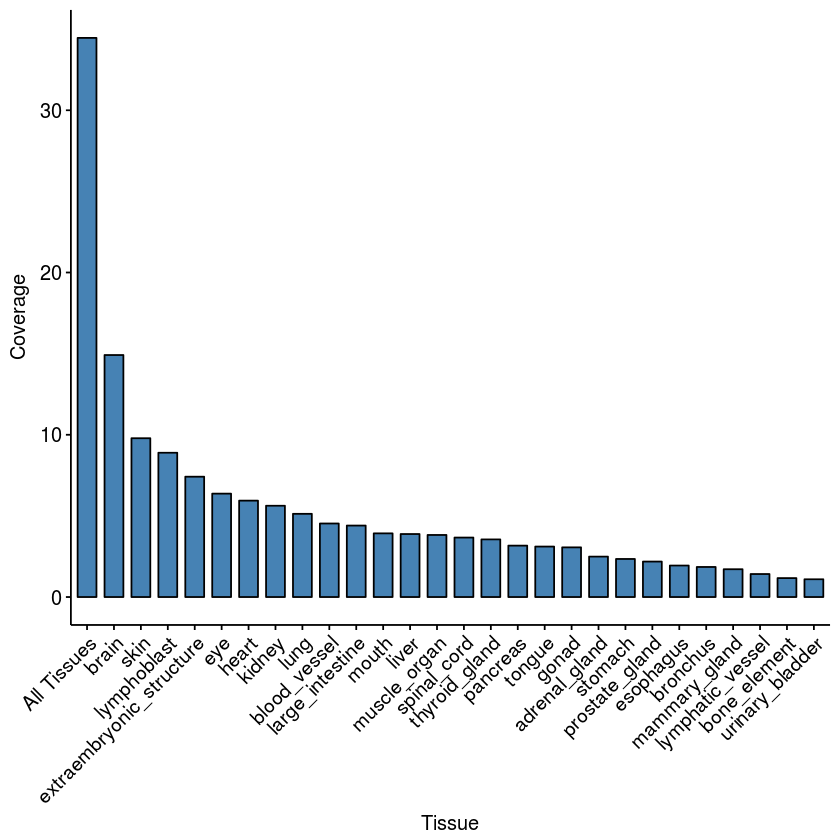

In [35]:
# Plot the whole shebang!
# Plot it
total.coverage %>% ggbarplot(x = "Tissue",
                              y = "Coverage",
                              fill = "steelblue",
                              x.text.angle = 45,
                              sort.val = "desc"                              
                             ) -> coverage.plot

# Save to a figure
png("./coveragePlot.png")
coverage.plot
dev.off()

# Show it
coverage.plot

In [ ]:
total.coverage

# Part 4 : Coverage above a certain HINT score

This is exactly the same as the above, but we need to grab things that are a certain threshold for HINT score AND Wellington score and assess coverage that way. Specifically, for each tissue:

1) Read in the footprint files to create a list
2) Collapse the list into a data frame
3) Filter for only the things that fall beyond a threshold (over 200 for HINT, under -27 for Wellington)
4) Collapse the data frame into a reduced GRanges object

This will give us everything we need for calculating the individual widths, plus we can combine them for the "all tissues" case. 

In [44]:
# Make a new function including the filter
# Function to turn tissue into reduced GR
findFilteredCoverage <- function(tissue, hintCutoff = 200, wellCutoff = -27){

    # First find the footprints
    fp <- compileFootprintPaths(tissue)

    # Then use a parallel process to read all the footprints; use 30 workers
    my.message <- sprintf("Reading %d files for %s", length(fp), tissue)
    message(my.message)
    register(MulticoreParam(workers = 30, stop.on.error = TRUE, log = FALSE), default = TRUE)
    fp.list <- bptry(bplapply(fp, readFootprintTable))
    
    # Filter on the criteria at the same time for each
    fp.filtered <- lapply(fp.list, filter, score > hintCutoff | score < wellCutoff)
    
    # Turn the footprint list into a genomic range
    fp.gr <- footprintsToGenomicRange(fp.filtered)
    rm(fp.list)
    
    # Reduce the genomic range
    reduced.gr <- GenomicRanges::reduce(fp.gr)
    
    # Return a reduced GR
    return(reduced.gr)
}

In [45]:
system.time(reduced.list <- lapply(all.tissues, findFilteredCoverage))

Reading 12 files for adrenal_gland
Reading 40 files for blood_vessel
Reading 4 files for bone_element
Reading 116 files for brain
Reading 8 files for bronchus
Reading 8 files for esophagus
Reading 44 files for extraembryonic_structure
Reading 32 files for eye
Reading 10 files for gonad
Reading 30 files for heart
Reading 32 files for kidney
Reading 20 files for large_intestine
Reading 10 files for liver
Reading 28 files for lung
Reading 8 files for lymphatic_vessel
Reading 84 files for lymphoblast
Reading 8 files for mammary_gland
Reading 16 files for mouth
Reading 14 files for muscle_organ
Reading 8 files for pancreas
Reading 8 files for prostate_gland
Reading 184 files for skin
Reading 8 files for spinal_cord
Reading 4 files for stomach
Reading 12 files for thyroid_gland
Reading 8 files for tongue
Reading 4 files for urinary_bladder


    user   system  elapsed 
4146.964  534.568 7068.265 

In [46]:
# Save the overall data frame
save(reduced.list, file = "./allTissueCoverageFiltered.Rdata")

In [47]:
# Make a small function to get total bp for all tissues
getCoverageFromGR <- function(reduced.range){
    total.bp <- sum(as.numeric(width(reduced.range)))   
    return(total.bp)
}


In [48]:
system.time(individual.coverages <- lapply(reduced.list, getCoverageFromGR))

   user  system elapsed 
  0.120   0.068   0.255 

In [49]:
# Make it into a DF
tissue.coverage <- data_frame(Tissue = all.tissues,
                              Total.Width = unlist(individual.coverages),
                              Coverage = 100*Total.Width/3253848404
                             )


In [50]:
# Put together everything to make the one big range for all tissues
reduced.grlist <- GRangesList(reduced.list)
big.gr <- unlist(reduced.grlist, recursive = TRUE, use.names = TRUE)

In [51]:
# Now combine the ranges, reduce, and use the widths operator to find full coverage
all.reduced <- GenomicRanges::reduce(big.gr)
    
# Sum the areas using the "width" operator to get each area
total.bp <- sum(as.numeric(width(all.reduced)))

In [52]:
# Add it to the other one
total.coverage <- data_frame(Tissue = 'All Tissues',
                              Total.Width = total.bp,
                              Coverage = 100*Total.Width/3253848404
                             )
total.coverage <- bind_rows(tissue.coverage, total.coverage) %>% arrange(desc(Total.Width))

In [53]:
# Save the overall data frame
save(total.coverage, file = "./allCoverageWithTotalFiltered.Rdata")

png 
  2

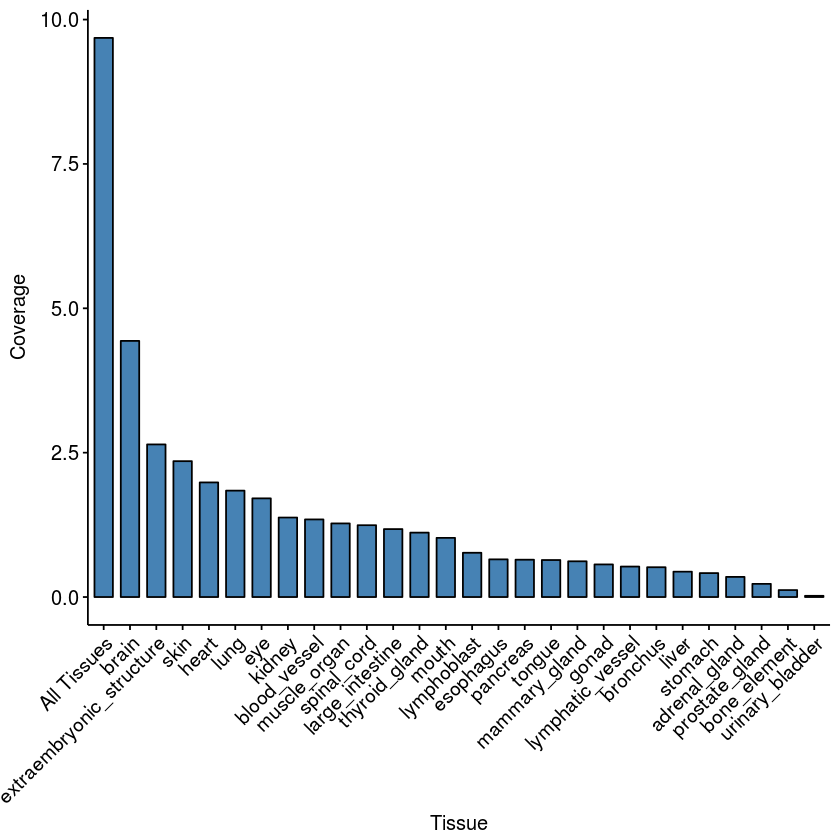

In [54]:
# Plot it
total.coverage %>% ggbarplot(x = "Tissue",
                              y = "Coverage",
                              fill = "steelblue",
                              x.text.angle = 45,
                              sort.val = "desc"                              
                             ) -> filtered.plot

# Save to a figure
png("./coverageFilteredPlot.png")
filtered.plot
dev.off()

# Show it
filtered.plot

## Important: Compare the 2 different coverages!



In [55]:
load("./allCoverageWithTotalFiltered.Rdata")
filtered <- total.coverage

load("./allCoverageWithTotal.Rdata")
unfiltered <- total.coverage

In [58]:
names(unfiltered)

[1] "Tissue"      "Total.Width" "Coverage"

In [60]:
compare <- filtered %>% left_join(unfiltered, by = "Tissue") %>% 
    mutate(diff = Total.Width.y - Total.Width.x, Percent.Diff = Coverage.y - Coverage.x) %>%
    select(Tissue, diff, Percent.Diff) %>% arrange(desc(Percent.Diff))
compare

Tissue,diff,Percent.Diff
All Tissues,806199545,24.7768010
brain,341006067,10.4800846
lymphoblast,264427245,8.1266000
skin,241930867,7.4352224
extraembryonic_structure,155349561,4.7743331
eye,151716208,4.6626698
kidney,138306873,4.2505629
heart,128732483,3.9563147
liver,112039788,3.4433008
lung,106935687,3.2864373


file saved to ./combinedCoverage.png


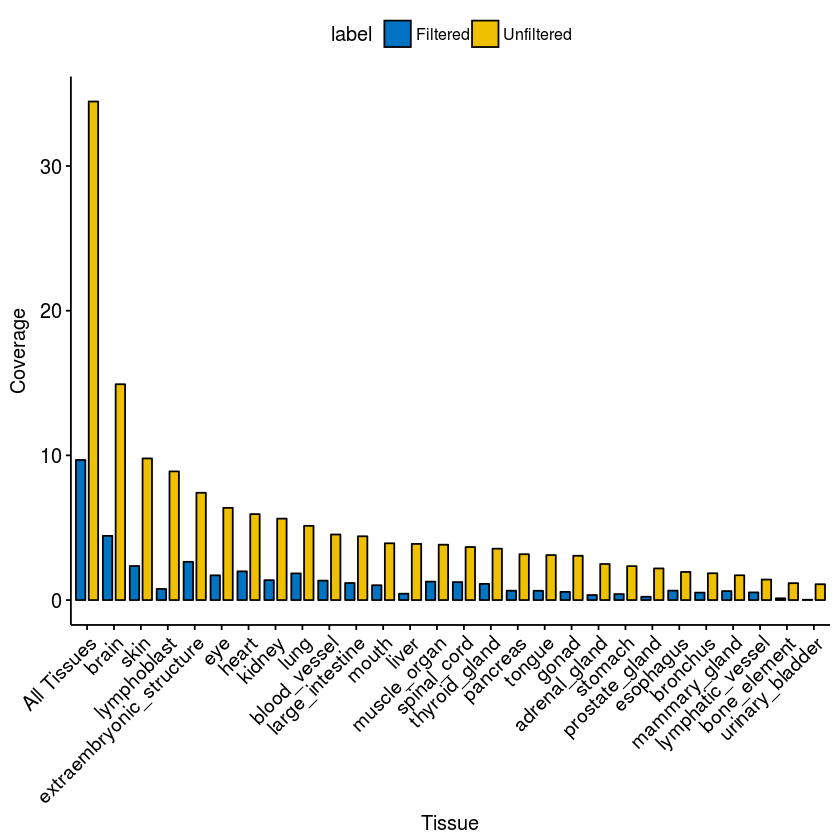

In [90]:
# Make a dual plot
filtered$label <- "Filtered"
filtered <- filtered %>% arrange(desc(Coverage))
unfiltered$label <- "Unfiltered"
unfiltered <- unfiltered %>% arrange(desc(Coverage))

both.data <- unfiltered %>% bind_rows(filtered)

# Plot it
both.data %>% ggbarplot(x = "Tissue",
                        y = "Coverage",
                        position = position_dodge(), # stack bars next to each other
                        fill = "label",
                        palette = "jco",
                        x.text.angle = 45) -> combined.coverage.plot

# Save it
combined.coverage.plot %>% ggexport(filename = "./combinedCoverage.png")

combined.coverage.plot

